In [1]:
import pandas as pd
from tqdm import tqdm

In [2]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

In [3]:
Y_set = pd.read_csv("/home/sander/apps/slim/ptm_predictions/ST_Phospho_Human_Peptides_2,7,30_Preds.csv")

In [4]:
run_paths = [
    "/public/compomics/sander/enriched/Orbitrap_Exploris_480/diann_results/Enriched_000_speclib.parquet",
    "/public/compomics/sander/enriched/Orbitrap_Exploris_480/diann_results/Enriched_005_speclib.parquet",
    "/public/compomics/sander/enriched/Orbitrap_Exploris_480/diann_results/Enriched_010_speclib.parquet",
    "/public/compomics/sander/enriched/Orbitrap_Exploris_480/diann_results/Enriched_020_speclib.parquet",
    "/public/compomics/sander/enriched/Orbitrap_Exploris_480/diann_results/Enriched_040_speclib.parquet",
    "/public/compomics/sander/enriched/Orbitrap_Exploris_480/diann_results/Enriched_080_speclib.parquet",
    "/public/compomics/sander/enriched/Orbitrap_Exploris_480/diann_results/Enriched_099_speclib.parquet"
]

In [5]:
def read_proteome(canonical_proteome):
    """
    Reads the proteome sequences from the FASTA file, filters X and U aa from proteome

    Parameters:
    canonical_proteome : str
        Path to the FASTA file containing the proteome sequences

    Returns:
    dict
        A dictionary where keys are protein IDs and values are sequences
        {prot1: 'PEPTIDERRRPEPTIDE...', ...}
    """
    sequences = {}  # {prot_id: sequence}
    with open(canonical_proteome, 'r') as f:
        prot_id = None
        seq_lines = []
        for line in f:
            line = line.strip()
            if line.startswith('>'):
                if prot_id:
                    sequence = ''.join(seq_lines)
                    if 'U' not in sequence and 'X' not in sequence:
                        sequences[prot_id] = sequence
                    seq_lines = []
                prot_id = line[1:].split()[0]
            else:
                seq_lines.append(line)
        if prot_id:
            sequence = ''.join(seq_lines)
            if 'U' not in sequence and 'X' not in sequence:
                sequences[prot_id] = sequence
    return sequences

canonical_proteome = '/home/sander/apps/slim/general_data/UP000005640_9606_prot_id.fasta'
proteome = read_proteome(canonical_proteome)

def digest_protein(sequence, missed_cleavages=0, min_length=0, max_length=None):
    """
    Performs trypsin digestion on a single protein sequence.

    Args:
        sequence (str): Protein sequence
        missed_cleavages (int): Number of allowed missed cleavages
        min_length (int): Minimum peptide length
        max_length (int): Maximum peptide length (None for no limit)

    Returns:
        list: List of tuples (peptide, start_pos) where start_pos is 0-based

    Example:
        Input: "PEPTIDERPRRPEPTIDE"
        Output: [('PEPTIDER', 0), ('PEPTIDERR', 0), ..., ('RPEPTIDE', 9)]
    """
    cleavage_sites = []
    for i in range(len(sequence) - 1):
        if sequence[i] in ('K', 'R'): # and sequence[i+1] != 'P':
            cleavage_sites.append(i+1)
    cleavage_sites = [0] + cleavage_sites + [len(sequence)]
    
    peptides = []
    for start_idx in range(len(cleavage_sites)-1):
        for end_idx in range(start_idx+1, min(len(cleavage_sites), start_idx+missed_cleavages+2)):
            pep_start = cleavage_sites[start_idx]
            pep_end = cleavage_sites[end_idx]
            peptide = sequence[pep_start:pep_end]
            if min_length <= len(peptide) <= (max_length if max_length else len(peptide)):
                # Validate that the peptide actually starts at pep_start
                assert sequence[pep_start:pep_start+len(peptide)] == peptide
                peptides.append((peptide, pep_start))
    return peptides

def calculate_miscleavages(peptide_seq, protein_seq, start_pos):
    """
    Calculates the number of missed cleavages in a single peptide.

    Args:
        peptide_seq (str): Peptide sequence
        protein_seq (str): Full protein sequence
        start_pos (int): Start position of peptide in protein (0-based)

    Returns:
        int: Number of missed cleavages

    Example:
        Input: ('PEPTIDERPR', 'PEPTIDERPRRPEPTIDE', 0)
        Output: 1
    """
    # Validate that the peptide actually occurs at start_pos
    assert protein_seq[start_pos:start_pos+len(peptide_seq)] == peptide_seq, \
           f"Peptide {peptide_seq} not found at position {start_pos} in protein"
    
    miscleavages = 0
    for i in range(len(peptide_seq)-1):  # Changed range to avoid going past peptide end
        abs_pos = start_pos + i  # Removed the -1 offset
        if protein_seq[abs_pos] in ('K', 'R'):
            miscleavages += 1
    return miscleavages

def trypsin_digest(sequences, missed_cleavages, min_length, max_length):
    """
    Performs trypsin digestion on all protein sequences.
    
    Args:
        sequences (dict): Dictionary of protein sequences {prot_id: sequence}
        missed_cleavages (int): Number of allowed missed cleavages
        min_length (int): Minimum peptide length
        max_length (int): Maximum peptide length

    Returns:
        list: List of dictionaries containing peptide information
        
    Example:
        Input: {'prot1': 'PEPTIDERRRPEPTIDE...', ...}
        Output: [{'prot_id': 'prot1', 'sequence': 'PEPTIDERPR', 'miscleavages': 1, 
                 'peptide_length': 10, 'start_pos': 0}, ...]
    """
    digested_peptides = []
    for prot_id, seq in sequences.items():
        peptides = digest_protein(seq, missed_cleavages, min_length, max_length)
        for peptide, start_pos in peptides:
            # Validate peptide position
            assert seq[start_pos:start_pos+len(peptide)] == peptide, \
                   f"Position mismatch for peptide {peptide} in protein {prot_id}"
            
            miscleavages = calculate_miscleavages(peptide, seq, start_pos)
            digested_peptides.append({
                'prot_id': prot_id,
                'sequence': peptide,
                'miscleavages': miscleavages,
                'peptide_length': len(peptide),
                'start_pos': start_pos
            })
    return digested_peptides

peptides = trypsin_digest(sequences = proteome, missed_cleavages = 2, min_length = 7, max_length = 30)

In [6]:
def results_to_sites(run_paths, peptides):
    """
    Process multiple DIANN proteomics results to identify phosphorylation sites.
    
    Args:
        run_paths (str or list): Path to a single parquet file or list of paths to parquet files.
        peptides (list): List of dictionaries containing reference peptide information.
        
    Returns:
        pd.DataFrame: Combined processed results with phosphosite information.
    """
    # Handle single path or list of paths
    if isinstance(run_paths, str):
        run_paths = [run_paths]
    
    # Create a dictionary for faster peptide lookup
    peptide_dict = {}
    for pep in peptides:
        peptide_dict.setdefault(pep['sequence'], []).append(pep)
    
    all_results = []
    
    # Process each run
    for run_path in tqdm(run_paths, desc='Processing runs'):
        # Load the run data
        diann_results = pd.read_parquet(run_path)
        
        # Filter results
        filtered_data = diann_results[
            (diann_results['Global.Peptidoform.Q.Value'] <= 0.01) & 
            (diann_results['Modified.Sequence'].str.contains('UniMod:21'))
        ].copy()
        
        # Process each peptidoform
        for idx, row in tqdm(filtered_data.iterrows(), 
                           total=filtered_data.shape[0], 
                           desc=f'Processing peptidoforms in {run_path}'):
            stripped_seq = row['Stripped.Sequence']
            
            # Find matching reference peptides
            matches = peptide_dict.get(stripped_seq, [])
            if not matches:
                print(f"Warning: No matching reference for {stripped_seq}")
                continue
                
            relative_pos = 0
            prob_string = row['Site.Occupancy.Probabilities']
            i = 0
            
            while i < len(prob_string):
                char = prob_string[i]
                
                if char.isalpha():  # Amino acid
                    relative_pos += 1
                    i += 1
                elif char == '(':  # Modification marker
                    while i < len(prob_string) and prob_string[i] != ')':
                        i += 1
                    i += 1
                elif char == '{':  # Localization score block
                    score_end = prob_string.find('}', i)
                    try:
                        current_score = float(prob_string[i+1:score_end])
                        # Add entry for each matching protein
                        for match in matches:
                            all_results.append({
                                'prot_id': match['prot_id'],
                                'position': match['start_pos'] + relative_pos,
                                'Q.Value': row['Global.Peptidoform.Q.Value'],
                                'PEP': row['PEP'],
                                'Localisation_score': current_score,
                                'shared': 1 if len(matches) > 1 else 0,
                                'run_id': run_path  # Add run identifier
                            })
                    except ValueError:
                        print(f"Warning: Unable to convert score {prob_string[i+1:score_end]} to float.")
                    i = score_end + 1
                else:
                    i += 1
    
    # Convert all results to DataFrame
    combined_df = pd.DataFrame(all_results)
    
    if len(combined_df) > 0:  # Check if we have any results
        # For each (prot_id, position, run_id) combination, keep the entry with the highest localization score
        combined_df = combined_df.sort_values('Localisation_score', ascending=False)
        combined_df = combined_df.drop_duplicates(subset=['prot_id', 'position', 'run_id'], keep='first')
    
    return combined_df

In [7]:
found_sites = results_to_sites(run_paths, peptides)

Processing peptidoforms in /public/compomics/sander/enriched/Orbitrap_Exploris_480/diann_results/Enriched_000_speclib.parquet: 100%|██████████| 3681/3681 [00:00<00:00, 24725.32it/s]
Processing peptidoforms in /public/compomics/sander/enriched/Orbitrap_Exploris_480/diann_results/Enriched_005_speclib.parquet: 100%|██████████| 4346/4346 [00:00<00:00, 22483.63it/s]
Processing peptidoforms in /public/compomics/sander/enriched/Orbitrap_Exploris_480/diann_results/Enriched_010_speclib.parquet: 100%|██████████| 5378/5378 [00:00<00:00, 23443.43it/s]
Processing peptidoforms in /public/compomics/sander/enriched/Orbitrap_Exploris_480/diann_results/Enriched_020_speclib.parquet: 100%|██████████| 3621/3621 [00:00<00:00, 21518.52it/s]
Processing peptidoforms in /public/compomics/sander/enriched/Orbitrap_Exploris_480/diann_results/Enriched_040_speclib.parquet: 100%|██████████| 3065/3065 [00:00<00:00, 24050.22it/s]
Processing peptidoforms in /public/compomics/sander/enriched/Orbitrap_Exploris_480/diann_r

In [8]:
train_sites = "/home/sander/apps/slim/ptm_predictions/Phospho-Sites_KnowledgeBase/train_combined.fasta"

In [9]:
def get_sites(filenames):
    """
    Input: 
        >Q9BSJ6
        MASRWQNMGT@S#VRRRS#LQHQEQLEDS@KELQPVVS@HQET@S@VGALGSLCRQFQRRLPLRAVNLNLRAGPSWKRLET#PEPGQQGLQAAARSAKS#ALGAVS@QRIQES@C...
        >...

    Processing: 
        Target sites are annotated with tailing symbols: @ means no modification has been found, # means modification on this residue has been found.
        The challenge here is to correctly determine the position of the amino acid without counting the annotations: # and @. 
        Only put a site in the dataframe when it has a positive annotation.  
        
    Output: 
        pandas dataframe:
        prot_id, position
        Q9BSJ6, 11
        Q9BSJ6, 16
        ...
    """
    sites = []
    current_protein = None

    # Iterate over each file
    for filename in filenames:
        current_protein = None
            
        with open(filename, 'r') as f:
            for line in f:
                line = line.strip()
                
                # Handle protein ID lines (starting with >)
                if line.startswith('>'):
                    current_protein = line[1:]  # Remove the '>' character
                    continue
                    
                # Handle sequence lines
                if current_protein and line:
                    # Initialize position counter (not counting annotations)
                    true_position = 0
                    
                    # Iterate through the sequence
                    for i, char in enumerate(line):
                        if char not in ['@', '#']:
                            # Increment position for actual amino acids
                            true_position += 1
                        elif char == '#':
                            # Add to our sites list
                            sites.append({
                                'prot_id': current_protein,
                                'position': true_position
                            })
    
    # Convert to pandas DataFrame
    df = pd.DataFrame(sites)
    
    # Sort by protein ID and position
    df = df.sort_values(['prot_id', 'position']).reset_index(drop=True)
    
    return df

In [10]:
train_sites = get_sites([train_sites])


In [11]:
train_sites.head()

,prot_id,position
0,A0A087WUL8,364
1,A0A096LP49,519
2,A0AVK6,52
3,A0AVK6,58
4,A0AVK6,71


In [12]:
found_sites_pred = pd.merge(
    found_sites,
    Y_set, 
    left_on = ['prot_id', 'position'],
    right_on = ['prot_id', 'position'],
    how = 'left'
)
found_sites_pred.head()

,prot_id,position,Q.Value,PEP,Localisation_score,shared,run_id,pred
0,Q8NAF0,483,0.000793,0.000844,1.0,0,/public/compomics/sander/enriched/Orbitrap_Exploris_480/diann_results/Enriched_000_speclib.parquet,0.9580
1,P24928,1878,0.001196,0.000017,1.0,0,/public/compomics/sander/enriched/Orbitrap_Exploris_480/diann_results/Enriched_080_speclib.parquet,0.9426
2,Q6SPF0,161,0.000793,0.001643,1.0,0,/public/compomics/sander/enriched/Orbitrap_Exploris_480/diann_results/Enriched_000_speclib.parquet,0.9569
3,Q9H1E3,214,0.001920,0.002142,1.0,0,/public/compomics/sander/enriched/Orbitrap_Exploris_480/diann_results/Enriched_005_speclib.parquet,0.9914
4,Q15311,29,0.001533,0.004851,1.0,0,/public/compomics/sander/enriched/Orbitrap_Exploris_480/diann_results/Enriched_005_speclib.parquet,0.9776


In [13]:
found_sites_pred = pd.merge(
    found_sites_pred,
    train_sites, 
    left_on = ['prot_id', 'position'],
    right_on = ['prot_id', 'position'],
    how = 'left'
)
found_sites_pred.head()

,prot_id,position,Q.Value,PEP,Localisation_score,shared,run_id,pred
0,Q8NAF0,483,0.000793,0.000844,1.0,0,/public/compomics/sander/enriched/Orbitrap_Exploris_480/diann_results/Enriched_000_speclib.parquet,0.9580
1,P24928,1878,0.001196,0.000017,1.0,0,/public/compomics/sander/enriched/Orbitrap_Exploris_480/diann_results/Enriched_080_speclib.parquet,0.9426
2,Q6SPF0,161,0.000793,0.001643,1.0,0,/public/compomics/sander/enriched/Orbitrap_Exploris_480/diann_results/Enriched_000_speclib.parquet,0.9569
3,Q9H1E3,214,0.001920,0.002142,1.0,0,/public/compomics/sander/enriched/Orbitrap_Exploris_480/diann_results/Enriched_005_speclib.parquet,0.9914
4,Q15311,29,0.001533,0.004851,1.0,0,/public/compomics/sander/enriched/Orbitrap_Exploris_480/diann_results/Enriched_005_speclib.parquet,0.9776


In [14]:
found_sites_pred['in_training'] = 0

# Iterate through rows in df1
for index, row in found_sites_pred.iterrows():
    # Check if this combination of prot_id and position exists in df2
    mask = (train_sites['prot_id'] == row['prot_id']) & (train_sites['position'] == row['position'])
    if mask.any():
        found_sites_pred.at[index, 'in_training'] = 1


In [15]:
found_sites_pred.head()

,prot_id,position,Q.Value,PEP,Localisation_score,shared,run_id,pred,in_training
0,Q8NAF0,483,0.000793,0.000844,1.0,0,/public/compomics/sander/enriched/Orbitrap_Exploris_480/diann_results/Enriched_000_speclib.parquet,0.9580,1
1,P24928,1878,0.001196,0.000017,1.0,0,/public/compomics/sander/enriched/Orbitrap_Exploris_480/diann_results/Enriched_080_speclib.parquet,0.9426,1
2,Q6SPF0,161,0.000793,0.001643,1.0,0,/public/compomics/sander/enriched/Orbitrap_Exploris_480/diann_results/Enriched_000_speclib.parquet,0.9569,1
3,Q9H1E3,214,0.001920,0.002142,1.0,0,/public/compomics/sander/enriched/Orbitrap_Exploris_480/diann_results/Enriched_005_speclib.parquet,0.9914,1
4,Q15311,29,0.001533,0.004851,1.0,0,/public/compomics/sander/enriched/Orbitrap_Exploris_480/diann_results/Enriched_005_speclib.parquet,0.9776,1


In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_localization_score_histogram(dataframe, bins=10, figsize=(10, 6), 
                                     title="Distribution of Localization Scores",
                                     save_path=None):
    """
    Plot a histogram of localization scores from a pandas DataFrame.
    
    Parameters:
    -----------
    dataframe : pandas.DataFrame
        DataFrame containing a 'Localisation score' column
    bins : int or sequence, default=10
        Number of bins or bin edges for the histogram
    figsize : tuple, default=(10, 6)
        Figure size (width, height) in inches
    title : str, default="Distribution of Localization Scores"
        Title for the plot
    save_path : str, optional
        If provided, save the figure to this path
        
    Returns:
    --------
    matplotlib.figure.Figure
        The created figure object
    """
    # Create figure and axis
    fig, ax = plt.subplots(figsize=figsize)
    
    # Plot histogram using seaborn for better aesthetics
    sns.histplot(data=dataframe, x='Localisation_score', bins=bins, kde=True, ax=ax)
    
    # Customize plot
    ax.set_title(title, fontsize=14)
    ax.set_xlabel('Localization Score', fontsize=12)
    ax.set_ylabel('Frequency', fontsize=12)
    
    # Add grid for better readability
    ax.grid(axis='y', alpha=0.3)
    
    # Add mean and median lines
    mean = dataframe['Localisation_score'].mean()
    median = dataframe['Localisation_score'].median()
    
    ax.axvline(mean, color='red', linestyle='--', linewidth=1.5, label=f'Mean: {mean:.3f}')
    ax.axvline(median, color='green', linestyle='-.', linewidth=1.5, label=f'Median: {median:.3f}')
    
    # Add legend
    ax.legend()
    
    plt.tight_layout()
    
    # Save figure if path is provided
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        
    return fig


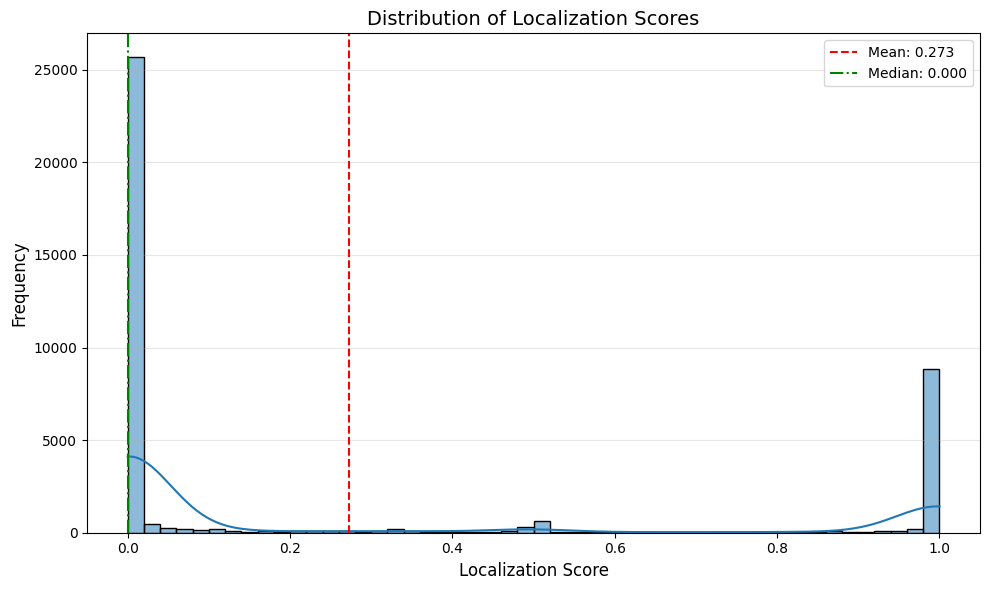

In [17]:
# Example usage:
plot_localization_score_histogram(found_sites_pred, bins=50)
plt.show()

In [18]:
# Get statistics for predictions by run_id, categorized by training status
# Assuming the dataframe is named found_sites_pred

# Group by 'run_id'
run_stats = {}

# Get unique run_ids
unique_run_ids = found_sites_pred['run_id'].unique()

for run_id in unique_run_ids:
    # Filter data for this run_id
    run_data = found_sites_pred[found_sites_pred['run_id'] == run_id]
    
    # Count sites with predictions in training data for this run
    in_training_count = run_data[run_data['pred'].notna() & 
                                (run_data['in_training'] == 1) &
                                (run_data['Localisation_score'] >= 0.50) &
                                (run_data['shared'] == 0)].shape[0]
    
    # Count sites with predictions not in training data for this run
    not_in_training_count = run_data[run_data['pred'].notna() & 
                                    (run_data['in_training'] == 0)  &
                                    (run_data['Localisation_score'] >= 0.50) &
                                    (run_data['shared'] == 0)].shape[0]
    
    # Total sites with predictions for this run
    total_with_predictions = in_training_count + not_in_training_count
    
    # Store statistics for this run
    run_stats[str(run_id)] = {
        'total_with_predictions': total_with_predictions,
        'in_training': in_training_count,
        'not_in_training': not_in_training_count
    }

# Print results by run_id
print("Statistics by run_id:")
print("-" * 80)
print(f"{'Run ID':<15} {'Total':<8} {'In Training':<12} {'Not In Training':<15} {'% In Training':<15} {'% Not In Training':<15}")
print("-" * 80)

for run_id, stats in run_stats.items():
    total = stats['total_with_predictions']
    if total > 0:
        pct_in = (stats['in_training'] / total * 100)
        pct_not_in = (stats['not_in_training'] / total * 100)
    else:
        pct_in = 0
        pct_not_in = 0
        
    print(f"{run_id:<15} {total:<8} {stats['in_training']:<12} {stats['not_in_training']:<15} {pct_in:<15.2f} {pct_not_in:<15.2f}")

# Also calculate overall statistics
total_predictions = sum(stats['total_with_predictions'] for stats in run_stats.values())
total_in_training = sum(stats['in_training'] for stats in run_stats.values())
total_not_in_training = sum(stats['not_in_training'] for stats in run_stats.values())

print("-" * 80)
print("Overall statistics:")
if total_predictions > 0:
    overall_pct_in = (total_in_training / total_predictions * 100)
    overall_pct_not_in = (total_not_in_training / total_predictions * 100)
else:
    overall_pct_in = 0
    overall_pct_not_in = 0
    
print(f"{'TOTAL':<15} {total_predictions:<8} {total_in_training:<12} {total_not_in_training:<15} {overall_pct_in:<15.2f} {overall_pct_not_in:<15.2f}")

Statistics by run_id:
--------------------------------------------------------------------------------
Run ID          Total    In Training  Not In Training % In Training   % Not In Training
--------------------------------------------------------------------------------
/public/compomics/sander/enriched/Orbitrap_Exploris_480/diann_results/Enriched_000_speclib.parquet 1891     1475         416             78.00           22.00          
/public/compomics/sander/enriched/Orbitrap_Exploris_480/diann_results/Enriched_080_speclib.parquet 871      678          193             77.84           22.16          
/public/compomics/sander/enriched/Orbitrap_Exploris_480/diann_results/Enriched_005_speclib.parquet 1754     1355         399             77.25           22.75          
/public/compomics/sander/enriched/Orbitrap_Exploris_480/diann_results/Enriched_010_speclib.parquet 2116     1646         470             77.79           22.21          
/public/compomics/sander/enriched/Orbitrap_Exploris_

In [19]:
import matplotlib.pyplot as plt
import numpy as np
import re
import pandas as pd

def plot_novel_sites(df):
    """
    Plot novel sites percentages with concentration codes (000, 005, etc.) as x-axis labels.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing prediction data with 'run_id', 'pred', 'in_training', 
        'Localisation_score', and 'shared' columns
    """
    # Get unique run_ids
    unique_run_ids = df['run_id'].unique()
    
    # Extract concentrations and calculate stats
    code_concentrations = []  # Store original codes (000, 005, etc.)
    percentages = []
    total_sites = []  # Track total sites for each concentration
    
    for run_id in unique_run_ids:
        # Extract concentration from run_id
        match = re.search(r'Enriched_(\d+)', run_id)
        if match:
            conc_code = match.group(1)  # Get the original code (000, 005, etc.)
            
            # Filter data for this run_id
            run_data = df[df['run_id'] == run_id]
            
            # Count sites with predictions in/not in training data
            in_training_count = run_data[run_data['pred'].notna() & 
                                        (run_data['in_training'] == 1) &
                                        (run_data['Localisation_score'] >= 0.50) &
                                        (run_data['shared'] == 0)].shape[0]
            
            not_in_training_count = run_data[run_data['pred'].notna() & 
                                            (run_data['in_training'] == 0) &
                                            (run_data['Localisation_score'] >= 0.50) &
                                            (run_data['shared'] == 0)].shape[0]
            
            # Calculate percentage
            total = in_training_count + not_in_training_count
            if total > 0:
                pct_novel = (not_in_training_count / total) * 100
            else:
                pct_novel = 0
            
            code_concentrations.append(conc_code)
            percentages.append(pct_novel)
            total_sites.append(total)  # Store total count
    
    # Create a DataFrame for easier sorting
    plot_data = pd.DataFrame({
        'code': code_concentrations,  # Original codes (000, 005, etc.)
        'percentage': percentages,
        'total_sites': total_sites
    })
    
    # Define the desired order of concentration codes
    code_order = ['000', '005', '010', '020', '040', '080', '099']
    
    # Make sure all expected concentrations are included
    for code in code_order:
        if code not in plot_data['code'].values:
            plot_data = pd.concat([
                plot_data, 
                pd.DataFrame({'code': [code], 'percentage': [0], 'total_sites': [0]})
            ], ignore_index=True)
    
    # Sort according to the desired order
    plot_data['code'] = pd.Categorical(plot_data['code'], 
                                     categories=code_order, ordered=True)
    plot_data = plot_data.sort_values('code')
    
    # Create figure and axis with the full border
    fig, ax = plt.subplots(figsize=(6, 6))
    
    # Create bar chart with the specified blue color
    bars = ax.bar(plot_data['code'], plot_data['percentage'], color='blue', width=0.7)
    
    # Increase tick label sizes
    ax.tick_params(axis='both', which='major', labelsize=22)
    
    # Add percentage labels on top of bars (including 0% where applicable)
    for i, (_, row) in enumerate(plot_data.iterrows()):
        if row['total_sites'] > 0:  # Only show labels where there were sites found
            ax.text(i, row['percentage'] + 1, f"{row['percentage']:.0f}%", 
                   ha='center', va='bottom', fontsize=22)
    
    # Set y-axis range with padding for labels
    max_pct = plot_data['percentage'].max()
    ax.set_ylim(0, max_pct * 1.2 if max_pct > 0 else 20)
    
    # Add gridlines
    ax.yaxis.grid(True, linestyle='--', alpha=0.7)
    ax.set_axisbelow(True)  # Place gridlines behind bars
    
    # Keep all spines visible (full border)
    for spine in ax.spines.values():
        spine.set_visible(True)
    
    # Adjust layout
    plt.tight_layout()
    
    # Show the plot
    plt.show()

# Example usage:
# plot_novel_sites(found_sites_pred)

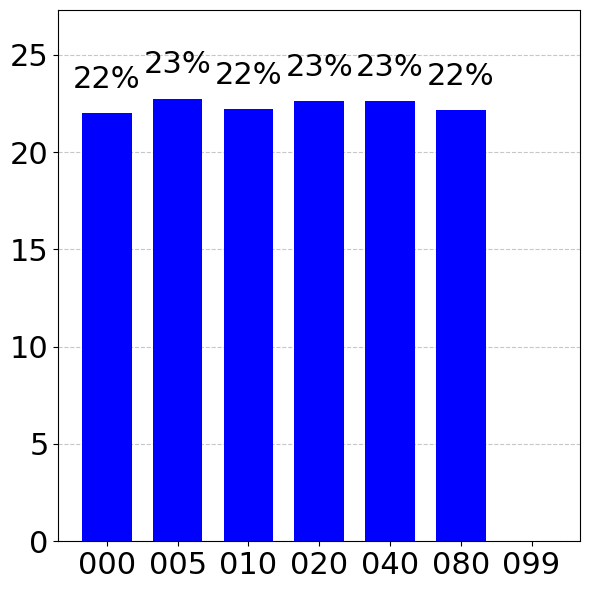

In [20]:
plot_novel_sites(found_sites_pred)

Total rows after filtering: 9490
Run codes found: ['000', '005', '010', '020', '040', '080']


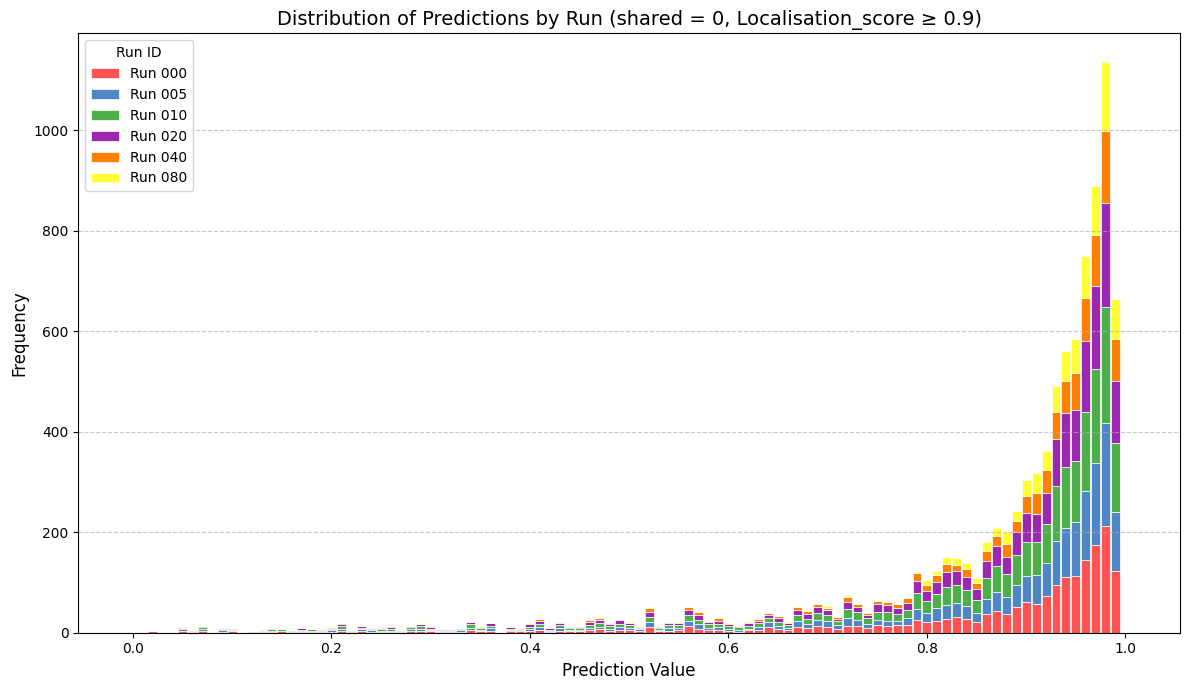

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

def plot_colored_prediction_distribution(df, bin_size=0.01):
    # Filter for shared=0, non-null predictions, and Localisation_score >= 0.9
    df = df[(df['shared'] == 0) & 
            (df['pred'].notna()) & 
            (df['Localisation_score'] >= 0.50)].copy()
    
    # Print diagnostic info
    print(f"Total rows after filtering: {len(df)}")
    
    # Extract the run number from the path in run_id
    pattern = r'Enriched_(\d+)_speclib\.parquet'
    df['run_code'] = df['run_id'].astype(str).apply(lambda x: re.search(pattern, x).group(1) if re.search(pattern, x) else 'unknown')
    
    # Create a new column for binned predictions
    df['pred_bin'] = (df['pred'] // bin_size) * bin_size
    df['pred_bin'] = df['pred_bin'].round(2)  # Fix floating point issues
    
    # Convert to long format with bin/run combinations
    bin_run_counts = df.groupby(['pred_bin', 'run_code']).size().reset_index(name='count')
    
    # Ensure all bin/run combinations exist (including zeros)
    bin_values = np.arange(0, 1 + bin_size/2, bin_size).round(2)
    run_codes = sorted(df['run_code'].unique())
    
    # Create all possible combinations
    all_combinations = []
    for bin_val in bin_values:
        for run in run_codes:
            all_combinations.append({'pred_bin': bin_val, 'run_code': run})
    
    # Convert to DataFrame and merge with counts
    all_df = pd.DataFrame(all_combinations)
    merged_df = pd.merge(all_df, bin_run_counts, on=['pred_bin', 'run_code'], how='left').fillna(0)
    
    # Print run codes for debugging
    print("Run codes found:", run_codes)
    
    # Define a custom color palette
    palette = {
        '000': '#FF5252',  # Red
        '005': '#4F86C6',  # Blue
        '010': '#4DAF4A',  # Green
        '020': '#9C27B0',  # Purple
        '040': '#FF7F00',  # Orange
        '080': '#FFFF33',  # Yellow
        '099': '#9E9E9E'   # Gray
    }
    
    # Create stacked bar chart manually
    fig, ax = plt.subplots(figsize=(12, 7))
    
    # Process data bin by bin
    bottom = np.zeros(len(bin_values))
    for run in run_codes:
        run_data = merged_df[merged_df['run_code'] == run]
        counts = np.zeros(len(bin_values))
        
        # Fill in counts for this run
        for i, bin_val in enumerate(bin_values):
            matched_row = run_data[run_data['pred_bin'] == bin_val]
            if not matched_row.empty:
                counts[i] = matched_row['count'].values[0]
        
        # Add this run's bars
        color = palette.get(run, '#333333')  # Default color if not in palette
        ax.bar(bin_values, counts, bottom=bottom, width=bin_size*0.9, 
              color=color, label=f'Run {run}', edgecolor='white', linewidth=0.5)
        
        # Update bottom for next run
        bottom += counts
    
    # Customize the plot
    ax.set_xlabel('Prediction Value', fontsize=12)
    ax.set_ylabel('Frequency', fontsize=12)
    ax.set_title('Distribution of Predictions by Run (shared = 0, Localisation_score ≥ 0.9)', fontsize=14)
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Set specific x-axis ticks
    specific_ticks = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
    ax.set_xticks(specific_ticks)
    ax.set_xticklabels([f'{x:.1f}' for x in specific_ticks])
    
    # Add legend
    ax.legend(title='Run ID')
    
    plt.tight_layout()
    plt.savefig('prediction_distribution_localization_filtered.png', dpi=300)
    plt.show()
    
    return merged_df  # Return the data for inspection

# Run the function
result_data = plot_colored_prediction_distribution(found_sites_pred)